In [3]:
import os, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


#Read training data
dataset = pd.read_csv('../data/Dataset_refined/btc_w_car_limitations.csv', sep=',')
dataset = dataset.drop(['velocity'], axis=1)
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values
print("Training Size: ", y.shape[0])

#Read test data
#test_set = pd.read_csv('../data/Dataset_refined/test_f6.csv', sep=',')
#test_set = test_set.drop(['velocity'], axis=1)
#test_set_X = test_set.iloc[:,0:-1].values
#test_set_y = test_set.iloc[:,-1].values
#print("Testing Size: ", test_set_y.shape[0])


os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Training Size:  10897


In [2]:
right_turns = y[np.where(y > 0.1)]
left_turns = y[np.where(y < -0.1)]
straight = y[np.where(abs(y) < 0.1)]
print("Number of Straight: ", straight.shape[0])
print("Number of right turns: ", right_turns.shape[0])
print("Number of left turns: ", left_turns.shape[0])
print("max: ", np.amax(y))
print("median: ", np.median(y))
print("min: ", np.amin(y))
print("Number of left turns: ", left_turns.shape[0])

Number of Straight:  7244
Number of right turns:  3458
Number of left turns:  4959
max:  0.4189000129699707
median:  -0.04473118111491203
min:  -0.4189000129699707
Number of left turns:  4959


In [34]:
dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,1072,1073,1074,1075,1076,1077,1078,1079,1080,steering_angle
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,...,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,1.546074,1.532822,1.519684,1.508848,1.497069,1.484899,1.473679,1.463179,1.452031,1.442898,...,2.053130,2.069219,2.107226,2.114062,2.149911,2.198493,2.174829,2.215040,2.220438,-0.026104
std,1.057151,1.040667,1.025918,1.018475,1.009149,0.999480,0.989791,0.982666,0.976010,0.970981,...,6.127650,6.169612,6.313436,6.293725,6.434450,6.630021,6.454853,6.610371,6.589992,0.233896
min,0.295000,0.297000,0.295000,0.287000,0.286000,0.285000,0.285000,0.282000,0.280000,0.282000,...,0.416000,0.422000,0.425000,0.425000,0.427000,0.435000,0.442000,0.444000,0.442000,-0.418900
25%,0.959000,0.956000,0.951000,0.947000,0.942000,0.938000,0.934000,0.930000,0.926000,0.922000,...,0.944000,0.951000,0.957000,0.964000,0.969000,0.978000,0.985000,0.992000,1.000000,-0.134009
50%,1.250000,1.244000,1.237000,1.230000,1.221000,1.212000,1.202000,1.197000,1.190000,1.184000,...,1.232000,1.237000,1.243000,1.249000,1.254000,1.260000,1.265000,1.271000,1.279000,-0.044731
75%,1.618000,1.608000,1.597000,1.588000,1.576000,1.566000,1.557000,1.548000,1.539000,1.531000,...,1.636000,1.644000,1.656000,1.666000,1.675000,1.685000,1.694000,1.705000,1.716000,0.070258
max,8.040000,8.080000,8.132000,8.177000,8.177000,8.085000,8.122000,8.141000,8.191000,8.186000,...,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,0.418900


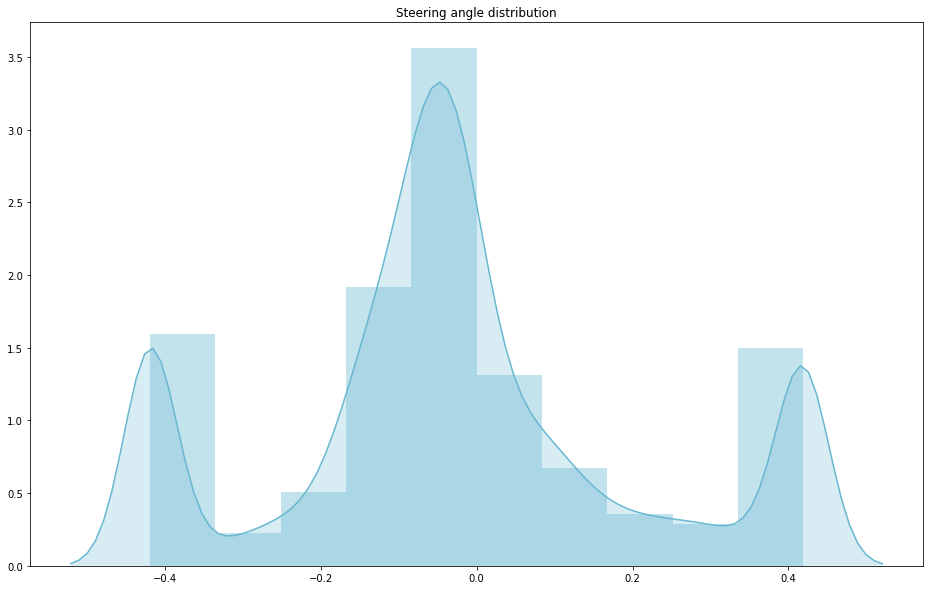

In [3]:
fig = plt.figure(figsize=(16,10))
# green - #3cb44b
# blue - #67B7D1
sns.distplot(y, bins=10, hist=True, kde_kws={"shade": True}, color='#67B7D1')
plt.title('Steering angle distribution', loc='center')
plt.show()

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

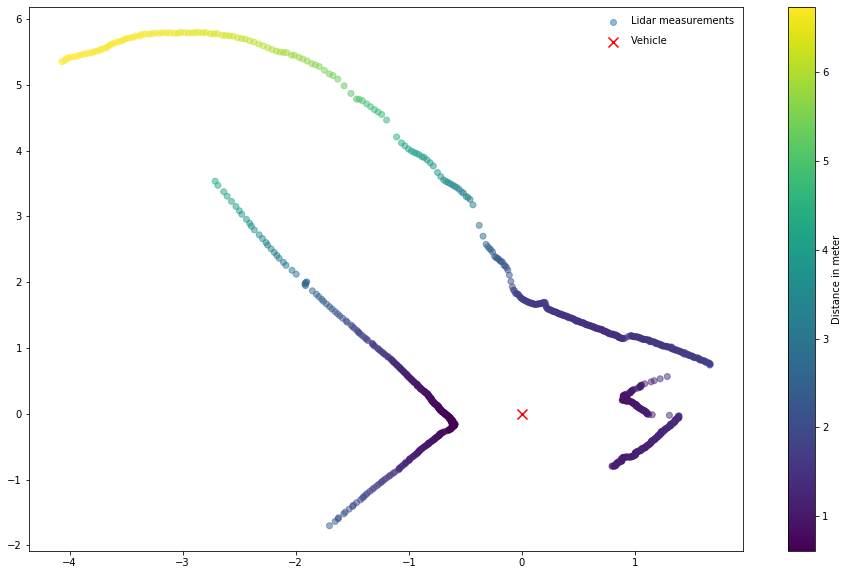

Output:  0.3844951391220093


In [11]:
#Plot data
angle_inc = math.radians(0.25)
angle_start = -math.radians(45)

SEQ_IDX= 500
data_plot= x_train[SEQ_IDX]

x = []
y = []

for i in range(len(data_plot)):
    angle = angle_start + i * angle_inc
    x.append(data_plot[i]*math.cos(angle))
    y.append(data_plot[i]*math.sin(angle))

norm = mpl.colors.Normalize(vmin=np.amin(data_plot), vmax=np.amax(data_plot))

fig = plt.figure(figsize=(16,10))
plt.scatter(x,y, c=(data_plot), cmap='viridis', marker='o', alpha=0.5, label='Lidar measurements')
plt.scatter(x=0, y=0,s=100, c='r', marker="x", label='Vehicle')
plt.axis(aspect='equal')

plt.colorbar(mpl.cm.ScalarMappable(norm=norm), label='Distance in meter')
plt.legend(labelspacing=1,frameon=False)
plt.show()
print("Output: ", y_train[SEQ_IDX])

In [44]:
#Normalization
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scaler.fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [34]:
#MLP Grid search model
mlp = MLPRegressor(max_iter=200)
parameter_space = {
    'hidden_layer_sizes': [(80,100,80)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.764 (+/-0.075) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.702 (+/-0.198) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 10, 5), 'learning_rate': 'constant', 'solver': 'adam'}


In [12]:
#Train MLP from Grid Search
mlp_best = MLPRegressor(
    hidden_layer_sizes=(80,100,80),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='constant',
    max_iter=200,
    early_stopping=True
)
mlp_best.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(80, 100, 80), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

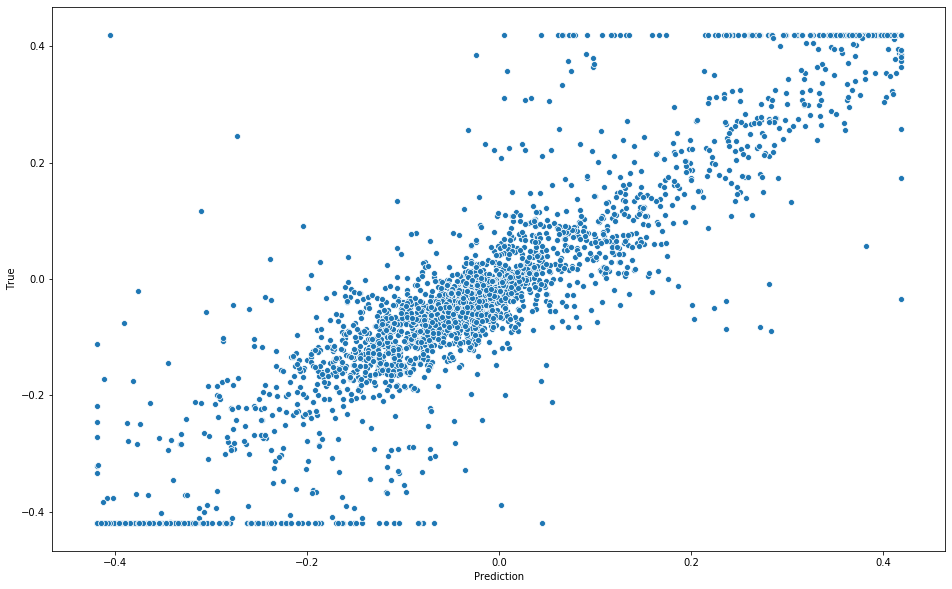

R2:  0.884094259505239
MAE:  0.048720997749703614
MSE:  0.006313956784737566


In [13]:
y_pred = mlp_best.predict(x_test)
y_pred = np.clip(y_pred, -0.4189, 0.4189)

results = pd.DataFrame()
results['Prediction'] = y_pred
results['True'] = y_test

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax1 = sns.scatterplot(x='Prediction', y='True', data=results, palette=cmap)
plt.show()
print("R2: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))

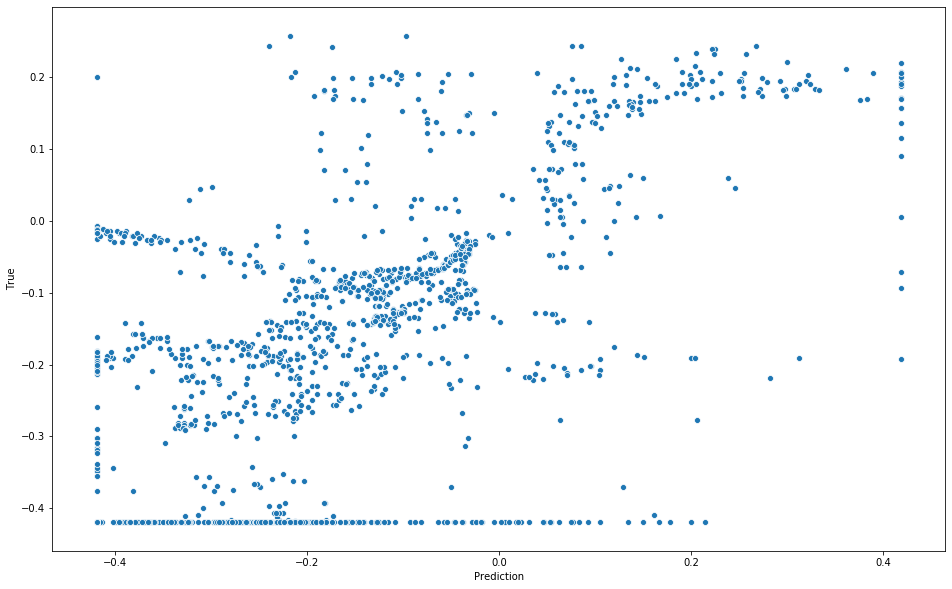

R2:  0.14431896260442234
MAE:  0.12359814817589408
MSE:  0.03064403684267784


In [15]:
#Normalize
scaler = MinMaxScaler()
scaler.fit(test_set_X)
test_set_X = scaler.transform(test_set_X)

#Predict
y_pred = mlp_best.predict(test_set_X)
y_pred = np.clip(y_pred, -0.4189, 0.4189)

results_test = pd.DataFrame()
results_test['Prediction'] = y_pred
results_test['True'] = test_set_y

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax1 = sns.scatterplot(x='Prediction', y='True', data=results_test, palette=cmap)
plt.show()
print("R2: ", r2_score(test_set_y, y_pred))
print("MAE: ", mean_absolute_error(test_set_y, y_pred))
print("MSE: ", mean_squared_error(test_set_y, y_pred))

In [4]:
#Keras sequential model
inputs = Input(shape=(360,))

dense1 = Dense(32)(inputs)
dense1 = Activation("relu")(dense1)

dense2 = Dense(64)(dense1)
dense2 = Activation("relu")(dense2)

dense3 = Dense(32)(dense2)
dense3 = Activation("relu")(dense3)


final = Dense(1)(dense3)

model = Model(inputs=inputs, outputs=final)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                11552     
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0     

In [5]:
from tensorflow.keras import metrics
model.compile(loss='mean_squared_error',
              optimizer= Adam(), metrics=[metrics.mae])

In [6]:
#preproccess 45 degrees = 180 iter

def preprocess(lidar):
    new_list = []
    count = 0
    
    for i in range (180, 900):
        if(count % 2):
            new_list.append(lidar[i])
        count +=1
    return np.array(new_list)
    

In [7]:
from sklearn.preprocessing import MinMaxScaler

X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values

processed_data = []
for x in X:
    processed_data.append(preprocess(x))

processed_data = np.array(processed_data)
scaler = MinMaxScaler()
scaler.fit(processed_data)
X = scaler.transform(processed_data)


x_t, x_v, y_t, y_v = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
BATCH_SIZE = 24 
EPOCHS = 30

history = model.fit(x_t,y_t,
                    verbose=1,
                    epochs= EPOCHS,
                    validation_data=(x_v,y_v))

Train on 8717 samples, validate on 2180 samples
Epoch 1/30
8717/8717 [==============================] - 2s 174us/sample - loss: 0.0157 - mean_absolute_error: 0.0868 - val_loss: 0.0095 - val_mean_absolute_error: 0.0676
Epoch 2/30
8717/8717 [==============================] - 1s 111us/sample - loss: 0.0092 - mean_absolute_error: 0.0653 - val_loss: 0.0080 - val_mean_absolute_error: 0.0595
Epoch 3/30
8717/8717 [==============================] - 1s 153us/sample - loss: 0.0078 - mean_absolute_error: 0.0584 - val_loss: 0.0072 - val_mean_absolute_error: 0.0566
Epoch 4/30
8717/8717 [==============================] - 1s 123us/sample - loss: 0.0071 - mean_absolute_error: 0.0557 - val_loss: 0.0072 - val_mean_absolute_error: 0.0587
Epoch 5/30
8717/8717 [==============================] - 1s 107us/sample - loss: 0.0067 - mean_absolute_error: 0.0542 - val_loss: 0.0062 - val_mean_absolute_error: 0.0510
Epoch 6/30
8717/8717 [==============================] - 1s 126us/sample - loss: 0.0063 - mean_absolute

In [42]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test MAE:', score[1])


Test loss: 14.244471338432207
Test MAE: 3.1708571910858154


In [9]:
model.save('mlp-small.h5')

In [1]:
import tensorflow as tf
tf.keras.backend.set_learning_phase(0) 
from tensorflow.keras.models import load_model
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile
import numpy as np
import time


MODEL_PATH = "./model/mlp-tf-small"

# load the Keras model
model = load_model('./model/mlp-small.h5')

# save the model to Tensorflow model
saver = tf.train.Saver()
sess = tf.keras.backend.get_session()
save_path = saver.save(sess, MODEL_PATH)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
#tf to TFRT
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
    saver = tf.train.import_meta_graph("./model/mlp-tf-small.meta")
    saver.restore(sess, "./model/mlp-tf-small")
    
    output_nodes = ["dense_3/BiasAdd"] #output layer
    
    # convert to frozen model
    frozen_graph = tf.compat.v1.graph_util.convert_variables_to_constants(
        sess, 
        tf.get_default_graph().as_graph_def(),
        output_node_names=output_nodes)
    
    with gfile.FastGFile("./model/frozen_model.pb", 'wb') as f:
        f.write(frozen_graph.SerializeToString())

INFO:tensorflow:Restoring parameters from ./model/mlp-tf-small
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
Instructions for updating:
Use tf.gfile.GFile.


In [3]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_nodes,
    max_batch_size=2,# specify your max batch size
    max_workspace_size_bytes=2*(10**9),# specify the max workspace
    precision_mode="FP32") # precision, can be "FP32" (32 floating point precision) or "FP16"

with gfile.FastGFile("./model/TensorRT_model.pb", 'wb') as f:
    f.write(trt_graph.SerializeToString())

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0


In [4]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in frozen_graph.node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 28
numb. of trt_engine_nodes in TensorRT graph: 0
numb. of all_nodes in TensorRT graph: 20


## Prediction

In [5]:
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [6]:
TENSORRT_MODEL_PATH = './model/TensorRT_model.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=1.0))) as sess:
        
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(trt_graph, name='')
        input = sess.graph.get_tensor_by_name('input_1:0')
        output = sess.graph.get_tensor_by_name('dense_3/BiasAdd:0')
        
        
        #testing with trash data
        
        lidar_func = lambda x : x if x <= 15.0 else 15.0
        lidar = np.array(np.random.rand(360) * 10)
        lidar = np.array([[ lidar_func(i)/15.0 for i in lidar ]])
        
        
        tot_time = 0
        for i in range(50):
            lidar = np.array(np.random.rand(360) * 10)
            lidar = np.array([[ lidar_func(i)/15.0 for i in lidar ]])
            start = time.time()
            out_pred = sess.run(output, feed_dict={input: lidar})
            end = time.time()
            tot_time = (end-start)
            print("Prediction: ", out_pred[0],"time: ", tot_time)
        print("avg time: ", tot_time/50)

Prediction:  [0.7342486] time:  0.05378389358520508
Prediction:  [0.63095665] time:  0.0009276866912841797
Prediction:  [0.5832516] time:  0.001470804214477539
Prediction:  [0.68040025] time:  0.0013158321380615234
Prediction:  [0.6654337] time:  0.0013990402221679688
Prediction:  [0.6657171] time:  0.0007259845733642578
Prediction:  [0.64351743] time:  0.0005729198455810547
Prediction:  [0.67448944] time:  0.0005145072937011719
Prediction:  [0.6118225] time:  0.00048661231994628906
Prediction:  [0.704556] time:  0.00038695335388183594
Prediction:  [0.6558322] time:  0.014931917190551758
Prediction:  [0.56067723] time:  0.0015785694122314453
Prediction:  [0.67276585] time:  0.0016472339630126953
Prediction:  [0.76945436] time:  0.000705718994140625
Prediction:  [0.649078] time:  0.0007660388946533203
Prediction:  [0.6673641] time:  0.0006222724914550781
Prediction:  [0.5883399] time:  0.010954618453979492
Prediction:  [0.76597166] time:  0.0014467239379882812
Prediction:  [0.6896103] t